In [3]:
import pandas as pd
import re
import os #folder path
from itertools import combinations

In [1]:
#import os

# Set this to the folder containing your data
#folder_path = *insert your folder path"

#if os.path.exists(folder_path):
    #print("Files in this folder:")
    #for file in os.listdir(folder_path):
        #print(f"- {file}")
#else:
    #print("The folder path itself is incorrect. Please check the folder names.")

In [37]:
# 1. Load your translated file
#df = pd.read_excel("Online_Review_Original_Data.xlsx")
#text_column = 'Comments'
#print("Success!")

### Dataset : Math Review Original Data

In [4]:
# 1. Load your file 
# If it is an Excel file:
file_path = "Math_Review_Original_Data.xlsx"
df = pd.read_excel(file_path)

# Assign the column name
text_column = 'Comments'

print("Success! File loaded and column assigned.")
# Preview the first few rows to make sure 'Comments' exists
df.head()

Success! File loaded and column assigned.


C:\Users\NUR MARDHIAH\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,Gender,Feedback-Original,Comments
0,Female,Saya ada ambil addmaths masa SPM dan benda tu ...,I took add maths during SPM and it traumatized...
1,Female,Agak takut dan risau sebab dah lama tak belaja...,Quite afraid and worried because I have not st...
2,Female,Saya tak ada basic addmath so saja agak risau....,I do not have a basic in add math so I am a bi...
3,Female,Saya bukan student yang bijak Matematik tapi s...,I am not a smart Mathematics student but I wil...
4,Female,Bagi saya matematik tidaklah Jurah sebab dah a...,"For me, mathematics is not that hard because I..."


### Word co-occurrence Analysis

In [41]:
# 2. Simple English stopword list
stop_words = {
    'a','about','above','after','again','against','all','am','an','and','any','are','as','at',
    'be','because','been','before','being','below','between','both','but','by',
    'can','could','did','do','does','doing','down','during','each','few','for','from','further',
    'had','has','have','having','he','her','here','hers','herself','him','himself','his','how',
    'i','if','in','into','is','it','its','itself','just','me','more','most','my','myself',
    'no','nor','not','now','of','off','on','once','only','or','other','our','ours','ourselves','out','over','own',
    's','same','she','should','so','some','such','t','than','that','the','their','theirs','them','themselves',
    'then','there','these','they','this','those','through','to','too','under','until','up','very','was','we','were','what',
    'when','where','which','while','who','whom','why','will','with','you','your','yours','yourself','yourselves'
}

# 3. Text cleaning + tokenization
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # Split into sentences by punctuation
    sentences = re.split(r'[.!?]', text.lower())
    sentence_tokens = []
    for sent in sentences:
        # Tokenize: keep alphabetic words only
        words = re.findall(r'\b[a-z]+\b', sent)
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
        if words:  # skip empty sentences
            sentence_tokens.append(words)
    return sentence_tokens

# 4. Apply preprocessing
df['sent_tokens'] = df[text_column].apply(preprocess_text)

# 5. Build sentence-level word co-occurrence pairs
cooccurrences = []
for sentences in df['sent_tokens']:
    for words in sentences:
        # sorted(set(words)) ensures unique pairs per sentence
        pairs = list(combinations(sorted(set(words)), 2))
        cooccurrences.extend(pairs)

# 6. Create co-occurrence dataframe
cooc_df = pd.DataFrame(cooccurrences, columns=['word1', 'word2'])

# 7. Count frequencies of each pair (Useful for Analysis)
cooc_counts = cooc_df.groupby(['word1', 'word2']).size().reset_index(name='count')
cooc_counts = cooc_counts.sort_values(by='count', ascending=False)

# 8. Save to CSV
cooc_counts.to_csv('sentence_level_cooccurrence.csv', index=False)

print("Analysis Complete. Top 10 pairs saved.")
print(cooc_counts.head(10))

Analysis Complete. Top 10 pairs saved.
      word1          word2  count
1054     dr           hope     15
2039   like           math      8
1780   hope           math      7
2257   math     understand      7
56      add           math      7
2253   math           time      6
1929  learn           math      6
2201   math  matriculation      6
1791   hope        subject      5
488     bit           math      5


### Sentiment Analysis 

In [46]:
#Install VADER:

!pip install vaderSentiment

#### Sentiment analysis : Line by Line for each student 

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1. Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# 2. Sentiment Analysis
# Using 'Comments' (matches the file provided)
text_column = 'Comments'

if text_column in df.columns:
    print(f"Analyzing sentiment for column: {text_column}...")
    df['neg'] = df[text_column].astype(str).apply(lambda x: analyzer.polarity_scores(x)['neg'])
    df['neu'] = df[text_column].astype(str).apply(lambda x: analyzer.polarity_scores(x)['neu'])
    df['pos'] = df[text_column].astype(str).apply(lambda x: analyzer.polarity_scores(x)['pos'])
    df['compound'] = df[text_column].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
    
    # Optional: Categorize sentiment based on compound score
    # Compound >= 0.05 (Positive), <= -0.05 (Negative), else Neutral
    df['sentiment_type'] = df['compound'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative' if c <= -0.05 else 'Neutral'))
else:
    print(f"Error: Column '{text_column}' not found. Please check the file.")

# 3. Save results
output_path = "VADER_Sentiment_Results.csv"
df.to_csv(output_path, index=False)
print(f"✅ Sentiment analysis complete! File saved as {output_path}")

# Display a preview
print(df[[text_column, 'compound', 'sentiment_type']].head())

Analyzing sentiment for column: Comments...
✅ Sentiment analysis complete! File saved as VADER_Sentiment_Results.csv
                                            Comments  compound sentiment_type
0  I took add maths during SPM and it traumatized...    0.8537       Positive
1  Quite afraid and worried because I have not st...   -0.5809       Negative
2  I do not have a basic in add math so I am a bi...    0.7876       Positive
3  I am not a smart Mathematics student but I wil...    0.9536       Positive
4  For me, mathematics is not that hard because I...    0.6614       Positive


#### Sentiment analysis : As overall

In [47]:
# 1. Calculate the Average Compound Score for the whole dataset
avg_compound = df['compound'].mean()

# 2. Determine the overall label
if avg_compound >= 0.05:
    overall_sentiment = "POSITIVE"
elif avg_compound <= -0.05:
    overall_sentiment = "NEGATIVE"
else:
    overall_sentiment = "NEUTRAL"

# 3. Get the count of each sentiment type
sentiment_counts = df['sentiment_type'].value_counts()
percentages = df['sentiment_type'].value_counts(normalize=True) * 100

print(f"--- OVERALL ANALYSIS ---")
print(f"Average Compound Score: {avg_compound:.4f}")
print(f"Overall Sentiment: {overall_sentiment}")
print(f"\n--- DISTRIBUTION ---")
print(sentiment_counts)
print(f"\n--- PERCENTAGES ---")
print(percentages.map('{:.2f}%'.format))

--- OVERALL ANALYSIS ---
Average Compound Score: 0.4063
Overall Sentiment: POSITIVE

--- DISTRIBUTION ---
Positive    41
Negative    13
Neutral      1
Name: sentiment_type, dtype: int64

--- PERCENTAGES ---
Positive    74.55%
Negative    23.64%
Neutral      1.82%
Name: sentiment_type, dtype: object


### Word Clouds 

In [48]:
#install word cloud

!pip install wordcloud matplotlib

     ------------------------------------- 306.5/306.5 kB 88.6 kB/s eta 0:00:00


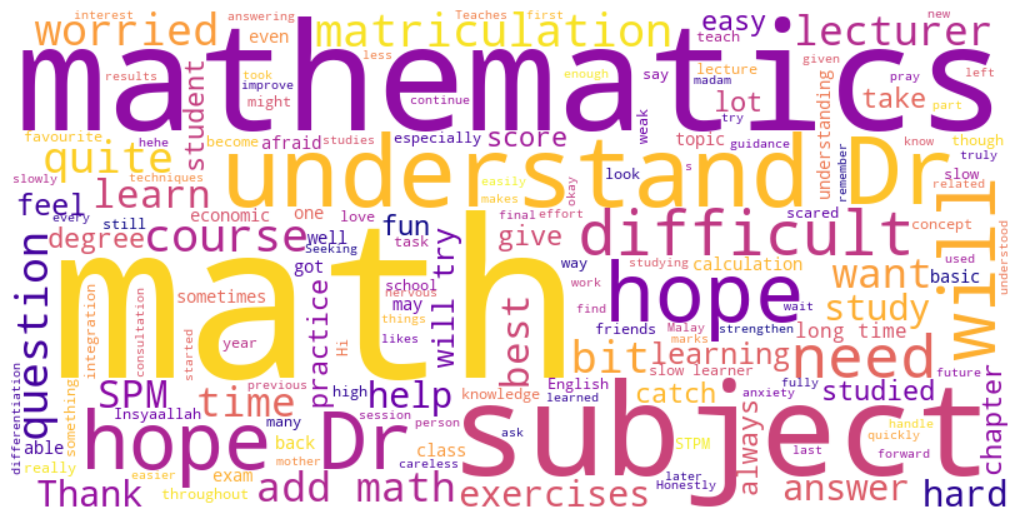

✅ Word Cloud generated and saved as student_feedback_wordcloud.png


In [52]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 1. Combine all comments into one big string
all_text = " ".join(comment for comment in df['Comments'].astype(str))

# 2. Add extra stopwords if needed 
# (Words like 'math' or 'subject' might be too big, you can add them here to hide them)
custom_stopwords = set(STOPWORDS)
# custom_stopwords.update(["math", "subject"]) # Uncomment this line to hide these words

# 3. Create the WordCloud object
wordcloud = WordCloud(
    width = 800, 
    height = 400, 
    background_color ='white', 
    stopwords = custom_stopwords, 
    min_font_size = 10,
    colormap='plasma' # You can change this to 'plasma', 'magma', or 'coolwarm'
).generate(all_text)

# 4. Plot the WordCloud image                        
plt.figure(figsize = (10, 5), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

# 5. Save the image
plt.savefig("student_feedback_wordcloud.png")
plt.show()

print("✅ Word Cloud generated and saved as student_feedback_wordcloud.png")

### File - Overall Result  

In [57]:
from itertools import combinations
from collections import Counter


# --- 5. COMBINE INTO ONE EXCEL FILE ---
output_file = "Final_Combined_Analysis.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df.to_excel(writer, sheet_name='Sentiment_Results', index=False)
    cooc_counts.to_excel(writer, sheet_name='Word_Co-occurrences', index=False)
    #word_freq.to_excel(writer, sheet_name='Word_Frequencies', index=False)

print(f"✅ All results combined! File saved as: {output_file}")

✅ All results combined! File saved as: Final_Combined_Analysis.xlsx
